<a href="https://colab.research.google.com/github/AnkurMali/IST597_SP21/blob/main/IST597_SP21_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IST597 :Recurrent Neural Networks (RNNs) for sequence classification
Thanks to @googleAI, @Keras, @madlalina @nvidia_research 
----

We will be  building a RNN for sentiment analysis on IMDB movie reviews ( [stanford_imdb](https://https://ai.stanford.edu/~amaas/data/sentiment/)). 


In [1]:
import tensorflow as tf
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
%matplotlib inline
seed=5097
tf.random.set_seed(seed)

In [2]:
import sys
sys.path.insert(1,'/content/')
from data_utils import parse_imdb_sequence

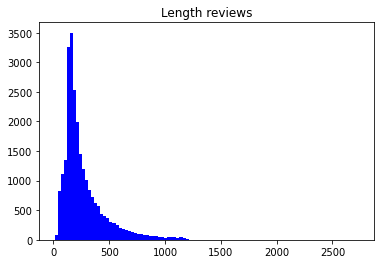

In [3]:
length_reviews = pickle.load(open('/content/length_reviews.pkl', 'rb'))
pd.DataFrame(length_reviews, columns=['Length reviews']).hist(bins=100, color='blue');
plt.grid(False);

In [4]:

train_dataset = tf.data.TFRecordDataset('/content/train.tfrecords')
eval_dataset=train_dataset.take(5000) 
train_dataset=train_dataset.skip(5000) 
train_dataset = train_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
#train_dataset = train_dataset.padded_batch(512, padded_shapes=([None],[],[]))

eval_dataset = eval_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
#eval_dataset = eval_dataset.padded_batch(512, padded_shapes=([None],[],[]))

test_dataset = tf.data.TFRecordDataset('/content/test.tfrecords')
test_dataset = test_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000,seed=seed)
#test_dataset = test_dataset.padded_batch(512, padded_shapes=([None],[],[]))

In [5]:
# Read the word vocabulary
word2idx = pickle.load(open('/content/word2idx.pkl', 'rb'))

## RNN model for sequence classification, compatible with Eager API 
----
In the cell below, you can find the class that I have created for the RNN model. The API is very similar with one I created in the previous tutorial, except that now we track the accuracy of the model instead of the loss.

The idea of the network is very simple. We simply take each word in the review, select its corresponding word embedding (initialized randomly in the beginning), and pass it through the RNN cell. We then take the output of the RNN cell at the end of the sequence and pass it through a dense layer (with ReLU activation) to obtain the final predictions. 

Like usually, the network inherits from tf.keras.Model in order to keep track of all variables and save/restore them easily.

![img](tutorials_graphics/rnn_imdb.png)

In [85]:
class RNNModel(tf.keras.Model):
    def __init__(self, embedding_size=100, cell_size=64, dense_size=128, 
                 num_classes=2, vocabulary_size=None, rnn_cell='lstm',
                 device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation on and the checkpoint
            directory. Additionaly, you can also modify the default size of the 
            network.
            
            Args:
                embedding_size: the size of the word embedding.
                cell_size: RNN cell size.
                dense_size: the size of the dense layer.
                num_classes: the number of labels in the network.
                vocabulary_size: the size of the word vocabulary.
                rnn_cell: string, either 'lstm' or 'ugrnn'.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        '''
        super(RNNModel, self).__init__()
        
        # Weights initializer function
        w_initializer = tf.compat.v1.keras.initializers.glorot_uniform()
    
        # Biases initializer function
        b_initializer = tf.zeros_initializer()
        
        # Initialize weights for word embeddings 
        self.embeddings = tf.keras.layers.Embedding(vocabulary_size, embedding_size, 
                                                    embeddings_initializer=w_initializer)
        
        # Dense layer initialization
        self.dense_layer = tf.keras.layers.Dense(dense_size, activation=tf.nn.relu, 
                                                 kernel_initializer=w_initializer, 
                                                 bias_initializer=b_initializer)
        
        # Predictions layer initialization
        self.pred_layer = tf.keras.layers.Dense(num_classes, activation=None, 
                                                kernel_initializer=w_initializer, 
                                                bias_initializer=b_initializer)
        
        # Basic LSTM cell
        if rnn_cell=='lstm':
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(cell_size)
        elif rnn_cell=='gru':
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.GRUCell(cell_size)
        # Else RNN cell
        else:
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(cell_size)
            
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        
    def predict(self, X, seq_length, is_training):
        '''
        Predicts the probability of each class, based on the input sample.

        Args:
            X: 2D tensor of shape (batch_size, time_steps).
            seq_length: the length of each sequence in the batch.
            is_training: Boolean. Either the network is predicting in
                         training mode or not.
        '''
        
        # Get the number of samples within a batch
        num_samples = tf.shape(X)[0]

        # Initialize LSTM cell state with zeros
        state = self.rnn_cell.zero_state(num_samples, dtype=tf.float32)
        
        # Get the embedding of each word in the sequence
        embedded_words = self.embeddings(X)
        
        # Unstack the embeddings
        unstacked_embeddings = tf.unstack(embedded_words, axis=1)
        
        # Iterate through each timestep and append the predictions
        outputs = []
        for input_step in unstacked_embeddings:
            output, state = self.rnn_cell(input_step, state)
            outputs.append(output)
            
        # Stack outputs to (batch_size, time_steps, cell_size)
        outputs = tf.stack(outputs, axis=1)
        
        # Extract the output of the last time step, of each sample
        idxs_last_output = tf.stack([tf.range(num_samples), 
                                     tf.cast(seq_length-1, tf.int32)], axis=1)
        final_output = tf.gather_nd(outputs, idxs_last_output)
        
        # Add dropout for regularization
        #dropped_output = tf.compat.v1.layers.Dropout(final_output, rate=0.3, training=is_training)
        
        # Pass the last cell state through a dense layer (ReLU activation)
        dense = self.dense_layer(final_output)
        
        # Compute the unnormalized log probabilities
        logits = self.pred_layer(dense)
        return logits
    
    def loss_fn(self, X, y, seq_length, is_training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(X, seq_length, is_training)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=preds)
        return loss
    
    def grads_fn(self, X, y, seq_length, is_training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(X, y, seq_length, is_training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,1)))
            dummy_length = tf.constant(1, shape=(1,))
            dummy_pred = self.predict(dummy_input, dummy_length, False)
            # Restore the variables of the model
            saver = tf.compat.v1.train.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.compat.v1.train.Saver(self.variables).save(save_path=self.checkpoint_directory, 
                                       global_step=global_step)   
    
    def evaluate(self,test_data,batch_size=1024):
        time_start = time.time()
        test_data = test_data.padded_batch(batch_size, padded_shapes=([None],[],[]))
        test_acc=tf.keras.metrics.Accuracy('test_acc')
        self.history['test_acc'] = []
        # Check accuracy test dataset
        for step, (X, y, seq_length) in enumerate(test_data):
          logits = self.predict(X, seq_length, False)
          preds = tf.argmax(logits, axis=1)
          test_acc(preds, y)
        self.history['test_acc'].append(test_acc.result().numpy())
        time_taken = time.time() - time_start
        print('Test accuracy for batch size {} is: {} in time {:.2f}\n\n ' .format(batch_size,self.history['test_acc'][-1],time_taken))
        
        #print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken)) 
        # Reset metrics
        test_acc.reset_states()
              
    def fit(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False,learningrate=1e-4,batch_size=1024):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the accuracy on the eval 
                                       dataset does not increase after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
        # Define optimizer.
        if optimizer=="Adam":
          optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learningrate)
        elif optimizer=="SGD":
          optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learningrate)
        elif optimizer=="RMSProp":
          optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=learningrate)

        #Batch size
        training_data = training_data.padded_batch(batch_size, padded_shapes=([None],[],[]))
        eval_data = eval_data.padded_batch(batch_size, padded_shapes=([None],[],[]))

        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best_acc. This variable will store the highest accuracy
        # on the eval dataset.
        best_acc = 0
        
        # Initialize classes to update the mean accuracy of train and eval
        train_acc = tf.keras.metrics.Accuracy('train_acc')
        eval_acc = tf.keras.metrics.Accuracy('eval_acc')
        
        
        # Initialize dictionary to store the accuracy history
        self.history = {}
        self.history['train_acc'] = []
        self.history['eval_acc'] = []
        
        #Time tracking
        time_start = time.time()

        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                for step, (X, y, seq_length) in enumerate(training_data):
                    grads = self.grads_fn(X, y, seq_length, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Check accuracy train dataset
                for step, (X, y, seq_length) in enumerate(training_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    train_acc(preds, y)
                self.history['train_acc'].append(train_acc.result().numpy())
                # Reset metrics
                train_acc.reset_states()

                # Check accuracy eval dataset
                for step, (X, y, seq_length) in enumerate(eval_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    eval_acc(preds, y)
                self.history['eval_acc'].append(eval_acc.result().numpy())
                # Reset metrics
                eval_acc.reset_states()
                
                
                # Print train and eval accuracy
                if (i==0) | ((i+1)%verbose==0):
                    #print('Epoch: {} -Train Accuracy:{:4f} - Eval Accuracy: {:4f} - Test Accuracy: {:4f} ' .format(i+1, self.history['train_acc'][-1],self.history['eval_acc'][-1],self.history['test_acc'][-1]))
                    print('Epoch: {} -Train Accuracy:{:4f} - Eval Accuracy: {:4f}' .format(i+1, self.history['train_acc'][-1],self.history['eval_acc'][-1]))
                    #print('Eval accuracy at epoch %d: ' %(i+1), self.history['eval_acc'][-1])

                # Check for early stopping
                if self.history['eval_acc'][-1]>best_acc:
                    best_acc = self.history['eval_acc'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break  
        time_taken = time.time() - time_start
        print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken)) 

## Train model with gradient descent and early stopping
----

### Model training with simple LSTM cells
----

In [7]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/LSTMRNN/'

# Use the GPU if available.
device = 'gpu:0'

# Instantiate model. This doesn't initialize the variables yet.
lstm_model = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)

# Train model
lstm_model.fit(train_dataset,eval_dataset, optimizer="Adam", num_epochs=10, 
                early_stopping_rounds=8, verbose=2, train_from_scratch=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Epoch: 1 -Train Accuracy:0.640350 - Eval Accuracy: 0.620400
Epoch: 2 -Train Accuracy:0.719900 - Eval Accuracy: 0.673000
Epoch: 4 -Train Accuracy:0.791850 - Eval Accuracy: 0.739800
Epoch: 6 -Train Accuracy:0.862950 - Eval Accuracy: 0.834800
Epoch: 8 -Train Accuracy:0.929650 - Eval Accuracy: 0.873400
Epoch: 10 -Train Accuracy:0.955600 - Eval Accuracy: 0.884200

Total time taken (in seconds): 433.16


In [8]:
#stm_model.save_model(global_step=0)
checkpoint = tf.train.Checkpoint(lstm_model)
save_path = checkpoint.save(checkpoint_directory)

In [9]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/LSTMRNNLB/'

# Use the GPU if available.
device = 'gpu:0'

# Instantiate model. This doesn't initialize the variables yet.
lstm_model_lb = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)

# Train model
lstm_model_lb.fit(train_dataset,eval_dataset, optimizer="Adam", num_epochs=10, 
                early_stopping_rounds=10, verbose=2, train_from_scratch=True,learningrate=1e-3,batch_size=512)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Epoch: 1 -Train Accuracy:0.910250 - Eval Accuracy: 0.877000
Epoch: 2 -Train Accuracy:0.958800 - Eval Accuracy: 0.873200
Epoch: 4 -Train Accuracy:0.984550 - Eval Accuracy: 0.864800
Epoch: 6 -Train Accuracy:0.998350 - Eval Accuracy: 0.869400
Epoch: 8 -Train Accuracy:0.996550 - Eval Accuracy: 0.861200
Epoch: 10 -Train Accuracy:0.998600 - Eval Accuracy: 0.875200

Total time taken (in seconds): 792.24


In [10]:
#stm_model.save_model(global_step=0)
checkpoint = tf.train.Checkpoint(lstm_model_lb)
save_path = checkpoint.save(checkpoint_directory)

In [11]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/LSTMRNNLB2/'

# Use the GPU if available.
device = 'gpu:0'

# Instantiate model. This doesn't initialize the variables yet.
lstm_model_lb2 = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)

# Train model
lstm_model_lb2.fit(train_dataset,eval_dataset, optimizer="Adam", num_epochs=10, 
                early_stopping_rounds=8, verbose=2, train_from_scratch=True,learningrate=1e-2,batch_size=256)
                

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Epoch: 1 -Train Accuracy:0.847400 - Eval Accuracy: 0.761200
Epoch: 2 -Train Accuracy:0.947250 - Eval Accuracy: 0.838800
Epoch: 4 -Train Accuracy:0.994400 - Eval Accuracy: 0.849400
Epoch: 6 -Train Accuracy:0.979450 - Eval Accuracy: 0.814200
Epoch: 8 -Train Accuracy:0.999400 - Eval Accuracy: 0.843000
Epoch: 10 -Train Accuracy:0.999550 - Eval Accuracy: 0.843200

Total time taken (in seconds): 1538.61


In [12]:
#stm_model.save_model(global_step=0)
checkpoint = tf.train.Checkpoint(lstm_model_lb2)
save_path = checkpoint.save(checkpoint_directory)

### Model training with RNN cells 
---

In [13]:

checkpoint_directory = 'models_checkpoints/UGRNN/'
# Use the GPU if available.
device = 'gpu:0'

# Instantiate model. This doesn't initialize the variables yet.
ugrnn_model = RNNModel(vocabulary_size=len(word2idx), rnn_cell='ugrnn', 
                       device=device, checkpoint_directory=checkpoint_directory)
# Train model
ugrnn_model.fit(train_dataset,eval_dataset,optimizer="Adam", num_epochs=10, 
                early_stopping_rounds=8, verbose=2, train_from_scratch=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:459: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + self._num_units, self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:463: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Epoch: 1 -Train Accuracy:0.571350 - Eval Accuracy: 0.557200
Epoch: 2 -Train Accuracy:0.679000 - Eval Accuracy: 0.591400
Epoch: 4 -Train Accuracy:0.770050 - Eval Accuracy: 0.596200
Epoch: 6 -Train Accuracy:0.869300 - Eval Accuracy: 0.561000
Epoch: 8 -Train Accuracy:0.928550 - Eval Accuracy: 0.546800
Epoch: 10 -Train Accuracy:0.964550 - Eval Accuracy: 0.532200

Total time taken (in seconds): 232.68


In [14]:
#ugrnn_model.save_model()
checkpoint = tf.train.Checkpoint(ugrnn_model)
save_path = checkpoint.save(checkpoint_directory)

In [15]:

checkpoint_directory = 'models_checkpoints/UGRNNLB/'
# Use the GPU if available.
device = 'gpu:0'

# Instantiate model. This doesn't initialize the variables yet.
ugrnn_model_lb = RNNModel(vocabulary_size=len(word2idx), rnn_cell='ugrnn', 
                       device=device, checkpoint_directory=checkpoint_directory)
# Train model
ugrnn_model_lb.fit(train_dataset,eval_dataset,optimizer="Adam", num_epochs=10, 
                early_stopping_rounds=8, verbose=2, train_from_scratch=True,learningrate=1e-3,batch_size=512)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:459: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + self._num_units, self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:463: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Epoch: 1 -Train Accuracy:0.705500 - Eval Accuracy: 0.690600
Epoch: 2 -Train Accuracy:0.911150 - Eval Accuracy: 0.839600
Epoch: 4 -Train Accuracy:0.962500 - Eval Accuracy: 0.841800
Epoch: 6 -Train Accuracy:0.992850 - Eval Accuracy: 0.856600
Epoch: 8 -Train Accuracy:0.976650 - Eval Accuracy: 0.787200
Epoch: 10 -Train Accuracy:0.996400 - Eval Accuracy: 0.837400

Total time taken (in seconds): 418.13


In [16]:
#ugrnn_model.save_model()
checkpoint = tf.train.Checkpoint(ugrnn_model_lb)
save_path = checkpoint.save(checkpoint_directory)

In [17]:

checkpoint_directory = 'models_checkpoints/UGRNNLB2/'
# Use the GPU if available.
device = 'gpu:0'

# Instantiate model. This doesn't initialize the variables yet.
ugrnn_model_lb2 = RNNModel(vocabulary_size=len(word2idx), rnn_cell='ugrnn', 
                       device=device, checkpoint_directory=checkpoint_directory)
# Train model
ugrnn_model_lb2.fit(train_dataset,eval_dataset,optimizer="Adam", num_epochs=10, 
                early_stopping_rounds=8, verbose=2, train_from_scratch=True,learningrate=1e-2,batch_size=256)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:459: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + self._num_units, self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:463: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Epoch: 1 -Train Accuracy:0.717650 - Eval Accuracy: 0.645600
Epoch: 2 -Train Accuracy:0.869350 - Eval Accuracy: 0.712200
Epoch: 4 -Train Accuracy:0.909000 - Eval Accuracy: 0.703600
Epoch: 6 -Train Accuracy:0.723250 - Eval Accuracy: 0.583400
Epoch: 8 -Train Accuracy:0.708500 - Eval Accuracy: 0.593800
Epoch: 10 -Train Accuracy:0.872600 - Eval Accuracy: 0.675200

Total time taken (in seconds): 777.82


In [18]:
#ugrnn_model.save_model()
checkpoint = tf.train.Checkpoint(ugrnn_model_lb2)
save_path = checkpoint.save(checkpoint_directory)

# Model Training with GRU

In [19]:
"""
checkpoint_directory = 'models_checkpoints/GRURNN/'
# Use the GPU if available.
device = 'gpu:0'

# Instantiate model. This doesn't initialize the variables yet.
gru_model = RNNModel(vocabulary_size=len(word2idx),rnn_cell="gru", device=device, 
                      checkpoint_directory=checkpoint_directory)
# Train model
gru_model.fit(train_dataset,eval_dataset,optimizer="Adam", num_epochs=10, 
                early_stopping_rounds=10, verbose=2, train_from_scratch=True)
"""

'\ncheckpoint_directory = \'models_checkpoints/GRURNN/\'\n# Use the GPU if available.\ndevice = \'gpu:0\'\n\n# Instantiate model. This doesn\'t initialize the variables yet.\ngru_model = RNNModel(vocabulary_size=len(word2idx),rnn_cell="gru", device=device, \n                      checkpoint_directory=checkpoint_directory)\n# Train model\ngru_model.fit(train_dataset,eval_dataset,optimizer="Adam", num_epochs=10, \n                early_stopping_rounds=10, verbose=2, train_from_scratch=True)\n'

In [20]:
#gru_model.save_model()
#checkpoint = tf.train.Checkpoint(gru_model)
#save_path = checkpoint.save(checkpoint_directory)

# Model Training with LSTM with SGD

In [21]:
"""
checkpoint_directory = 'models_checkpoints/LSTMRNN_SGD/'
# Use the GPU if available.
device = 'gpu:0'

# Instantiate model. This doesn't initialize the variables yet.
lstm_model_SGD = RNNModel(cell_size=32,vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)
# Train model
lstm_model_SGD.fit(train_dataset,eval_dataset, optimizer="SGD", num_epochs=10, 
                early_stopping_rounds=10, verbose=2, train_from_scratch=True)
                """

'\ncheckpoint_directory = \'models_checkpoints/LSTMRNN_SGD/\'\n# Use the GPU if available.\ndevice = \'gpu:0\'\n\n# Instantiate model. This doesn\'t initialize the variables yet.\nlstm_model_SGD = RNNModel(cell_size=32,vocabulary_size=len(word2idx), device=device, \n                      checkpoint_directory=checkpoint_directory)\n# Train model\nlstm_model_SGD.fit(train_dataset,eval_dataset, optimizer="SGD", num_epochs=10, \n                early_stopping_rounds=10, verbose=2, train_from_scratch=True)\n                '

In [22]:

#lstm_model_SGD.save_model()
#checkpoint = tf.train.Checkpoint(lstm_model_SGD)
#save_path = checkpoint.save(checkpoint_directory)

In [23]:
"""
checkpoint_directory = 'models_checkpoints/LSTMRNN_SGD_LB/'
# Use the GPU if available.
device = 'gpu:0'

# Instantiate model. This doesn't initialize the variables yet.
lstm_model_SGD_lb = RNNModel(cell_size=32,vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)
# Train model
lstm_model_SGD_lb.fit(train_dataset,eval_dataset, optimizer="SGD", num_epochs=10, 
                early_stopping_rounds=10, verbose=2, train_from_scratch=True,learningrate=1e-3,batch_size=512)
                """

'\ncheckpoint_directory = \'models_checkpoints/LSTMRNN_SGD_LB/\'\n# Use the GPU if available.\ndevice = \'gpu:0\'\n\n# Instantiate model. This doesn\'t initialize the variables yet.\nlstm_model_SGD_lb = RNNModel(cell_size=32,vocabulary_size=len(word2idx), device=device, \n                      checkpoint_directory=checkpoint_directory)\n# Train model\nlstm_model_SGD_lb.fit(train_dataset,eval_dataset, optimizer="SGD", num_epochs=10, \n                early_stopping_rounds=10, verbose=2, train_from_scratch=True,learningrate=1e-3,batch_size=512)\n                '

In [24]:
#lstm_model_SGD.save_model()
#checkpoint = tf.train.Checkpoint(lstm_model_SGD_lb)
#save_path = checkpoint.save(checkpoint_directory)

In [25]:
"""
checkpoint_directory = 'models_checkpoints/LSTMRNN_SGD_lB2/'
# Use the GPU if available.
device = 'gpu:0'

# Instantiate model. This doesn't initialize the variables yet.
lstm_model_SGD_lb2 = RNNModel(cell_size=32,vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)
# Train model
lstm_model_SGD_lb2.fit(train_dataset,eval_dataset, optimizer="SGD", num_epochs=10, 
                early_stopping_rounds=10, verbose=2, train_from_scratch=True,learningrate=1e-2,batch_size=256)
                """

'\ncheckpoint_directory = \'models_checkpoints/LSTMRNN_SGD_lB2/\'\n# Use the GPU if available.\ndevice = \'gpu:0\'\n\n# Instantiate model. This doesn\'t initialize the variables yet.\nlstm_model_SGD_lb2 = RNNModel(cell_size=32,vocabulary_size=len(word2idx), device=device, \n                      checkpoint_directory=checkpoint_directory)\n# Train model\nlstm_model_SGD_lb2.fit(train_dataset,eval_dataset, optimizer="SGD", num_epochs=10, \n                early_stopping_rounds=10, verbose=2, train_from_scratch=True,learningrate=1e-2,batch_size=256)\n                '

In [26]:
#lstm_model_SGD.save_model()
#checkpoint = tf.train.Checkpoint(lstm_model_SGD_lb2)
#save_path = checkpoint.save(checkpoint_directory)

# Model Training with RNN with SGD

In [27]:

"""
checkpoint_directory = 'models_checkpoints/UGRNN_SGD/'
# Use the GPU if available.
device = 'gpu:0'


# Instantiate model. This doesn't initialize the variables yet.
ugrnn_model_SGD = RNNModel(cell_size=128,vocabulary_size=len(word2idx),rnn_cell="gru", device=device, 
                      checkpoint_directory=checkpoint_directory)
# Train model
ugrnn_model_SGD.fit(train_dataset,eval_dataset, optimizer="SGD", num_epochs=10, 
                early_stopping_rounds=10, verbose=2, train_from_scratch=True)
                """

'\ncheckpoint_directory = \'models_checkpoints/UGRNN_SGD/\'\n# Use the GPU if available.\ndevice = \'gpu:0\'\n\n\n# Instantiate model. This doesn\'t initialize the variables yet.\nugrnn_model_SGD = RNNModel(cell_size=128,vocabulary_size=len(word2idx),rnn_cell="gru", device=device, \n                      checkpoint_directory=checkpoint_directory)\n# Train model\nugrnn_model_SGD.fit(train_dataset,eval_dataset, optimizer="SGD", num_epochs=10, \n                early_stopping_rounds=10, verbose=2, train_from_scratch=True)\n                '

In [28]:
"""
#gru_model_SGD.save_model()
checkpoint = tf.train.Checkpoint(ugrnn_model_SGD)
save_path = checkpoint.save(checkpoint_directory)
"""

'\n#gru_model_SGD.save_model()\ncheckpoint = tf.train.Checkpoint(ugrnn_model_SGD)\nsave_path = checkpoint.save(checkpoint_directory)\n'

In [29]:
"""
checkpoint_directory = 'models_checkpoints/UGRNN_SGD_LB/'
# Use the GPU if available.
device = 'gpu:0'


# Instantiate model. This doesn't initialize the variables yet.
ugrnn_model_SGD_lb = RNNModel(cell_size=128,vocabulary_size=len(word2idx),rnn_cell="gru", device=device, 
                      checkpoint_directory=checkpoint_directory)
# Train model
ugrnn_model_SGD_lb.fit(train_dataset,eval_dataset, optimizer="SGD", num_epochs=10, 
                early_stopping_rounds=10, verbose=2, train_from_scratch=True,learningrate=1e-2,batch_size=512)
                """

'\ncheckpoint_directory = \'models_checkpoints/UGRNN_SGD_LB/\'\n# Use the GPU if available.\ndevice = \'gpu:0\'\n\n\n# Instantiate model. This doesn\'t initialize the variables yet.\nugrnn_model_SGD_lb = RNNModel(cell_size=128,vocabulary_size=len(word2idx),rnn_cell="gru", device=device, \n                      checkpoint_directory=checkpoint_directory)\n# Train model\nugrnn_model_SGD_lb.fit(train_dataset,eval_dataset, optimizer="SGD", num_epochs=10, \n                early_stopping_rounds=10, verbose=2, train_from_scratch=True,learningrate=1e-2,batch_size=512)\n                '

In [30]:
#gru_model_SGD.save_model()
#checkpoint = tf.train.Checkpoint(ugrnn_model_SGD_lb)
#save_path = checkpoint.save(checkpoint_directory)

In [31]:
"""
checkpoint_directory = 'models_checkpoints/UGRNN_SGD_LB2/'
# Use the GPU if available.
device = 'gpu:0'


# Instantiate model. This doesn't initialize the variables yet.
ugrnn_model_SGD_lb2 = RNNModel(cell_size=128,vocabulary_size=len(word2idx),rnn_cell="gru", device=device, 
                      checkpoint_directory=checkpoint_directory)
# Train model
ugrnn_model_SGD_lb2.fit(train_dataset,eval_dataset, optimizer="SGD", num_epochs=10, 
                early_stopping_rounds=10, verbose=2, train_from_scratch=True,learningrate=1e-2,batch_size=256)
"""

'\ncheckpoint_directory = \'models_checkpoints/UGRNN_SGD_LB2/\'\n# Use the GPU if available.\ndevice = \'gpu:0\'\n\n\n# Instantiate model. This doesn\'t initialize the variables yet.\nugrnn_model_SGD_lb2 = RNNModel(cell_size=128,vocabulary_size=len(word2idx),rnn_cell="gru", device=device, \n                      checkpoint_directory=checkpoint_directory)\n# Train model\nugrnn_model_SGD_lb2.fit(train_dataset,eval_dataset, optimizer="SGD", num_epochs=10, \n                early_stopping_rounds=10, verbose=2, train_from_scratch=True,learningrate=1e-2,batch_size=256)\n'

In [32]:
#gru_model_SGD.save_model()
#checkpoint = tf.train.Checkpoint(ugrnn_model_SGD_lb2)
#save_path = checkpoint.save(checkpoint_directory)

# Model Training LSTM with RMSprop

In [33]:
checkpoint_directory = 'models_checkpoints/LSTMRNN_RMS/'
# Use the GPU if available.
device = 'cpu:0'

# Instantiate model. This doesn't initialize the variables yet.
lstm_model_RMS = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)
# Train model
lstm_model_RMS.fit(train_dataset,eval_dataset, optimizer="RMSProp", num_epochs=10, 
                early_stopping_rounds=8, verbose=2, train_from_scratch=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Epoch: 1 -Train Accuracy:0.520100 - Eval Accuracy: 0.527600
Epoch: 2 -Train Accuracy:0.561750 - Eval Accuracy: 0.568600
Epoch: 4 -Train Accuracy:0.585000 - Eval Accuracy: 0.584600
Epoch: 6 -Train Accuracy:0.709500 - Eval Accuracy: 0.690800
Epoch: 8 -Train Accuracy:0.790600 - Eval Accuracy: 0.791000
Epoch: 10 -Train Accuracy:0.843300 - Eval Accuracy: 0.818400

Total time taken (in seconds): 2087.20


In [34]:
#lstm_model_RMS.save_model()
checkpoint = tf.train.Checkpoint(lstm_model_RMS)
save_path = checkpoint.save(checkpoint_directory)

In [35]:
checkpoint_directory = 'models_checkpoints/LSTMRNN_RMS_LB/'
# Use the GPU if available.
device = 'cpu:0'

# Instantiate model. This doesn't initialize the variables yet.
lstm_model_RMS_lb = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)
# Train model
lstm_model_RMS_lb.fit(train_dataset,eval_dataset, optimizer="RMSProp", num_epochs=10, 
                early_stopping_rounds=8, verbose=2, train_from_scratch=True,learningrate=1e-3,batch_size=512)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Epoch: 1 -Train Accuracy:0.550150 - Eval Accuracy: 0.554000
Epoch: 2 -Train Accuracy:0.638800 - Eval Accuracy: 0.631600
Epoch: 4 -Train Accuracy:0.904600 - Eval Accuracy: 0.850600
Epoch: 6 -Train Accuracy:0.945250 - Eval Accuracy: 0.862000
Epoch: 8 -Train Accuracy:0.951000 - Eval Accuracy: 0.861200
Epoch: 10 -Train Accuracy:0.965400 - Eval Accuracy: 0.854800

Total time taken (in seconds): 2384.80


In [36]:
#lstm_model_RMS.save_model()
checkpoint = tf.train.Checkpoint(lstm_model_RMS_lb)
save_path = checkpoint.save(checkpoint_directory)

In [37]:
checkpoint_directory = 'models_checkpoints/LSTMRNN_RMS_LB2/'
# Use the GPU if available.
device = 'cpu:0'

# Instantiate model. This doesn't initialize the variables yet.
lstm_model_RMS_lb2 = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)
# Train model
lstm_model_RMS_lb2.fit(train_dataset,eval_dataset, optimizer="RMSProp", num_epochs=10, 
                early_stopping_rounds=10, verbose=2, train_from_scratch=True,learningrate=1e-2,batch_size=256)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Epoch: 1 -Train Accuracy:0.675300 - Eval Accuracy: 0.658200
Epoch: 2 -Train Accuracy:0.781800 - Eval Accuracy: 0.748400
Epoch: 4 -Train Accuracy:0.909450 - Eval Accuracy: 0.858000
Epoch: 6 -Train Accuracy:0.987000 - Eval Accuracy: 0.881600
Epoch: 8 -Train Accuracy:0.996950 - Eval Accuracy: 0.877200
Epoch: 10 -Train Accuracy:0.998850 - Eval Accuracy: 0.880600

Total time taken (in seconds): 3084.40


In [38]:
#lstm_model_RMS.save_model()
checkpoint = tf.train.Checkpoint(lstm_model_RMS_lb2)
save_path = checkpoint.save(checkpoint_directory)

# Model Training  RNN WITH RMSProp

In [52]:
checkpoint_directory = 'models_checkpoints/UGRNN_RMS/'
# Use the GPU if available.
device = 'cpu:0'


# Instantiate model. This doesn't initialize the variables yet.
ugrnn_model_RMS = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)
# Train model
ugrnn_model_RMS.fit(train_dataset,eval_dataset, optimizer="RMSProp", num_epochs=10, 
                early_stopping_rounds=10, verbose=2, train_from_scratch=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Epoch: 1 -Train Accuracy:0.536300 - Eval Accuracy: 0.524000
Epoch: 2 -Train Accuracy:0.553800 - Eval Accuracy: 0.544200
Epoch: 4 -Train Accuracy:0.612850 - Eval Accuracy: 0.609400
Epoch: 6 -Train Accuracy:0.701900 - Eval Accuracy: 0.689200
Epoch: 8 -Train Accuracy:0.783000 - Eval Accuracy: 0.771600
Epoch: 10 -Train Accuracy:0.854750 - Eval Accuracy: 0.825800

Total time taken (in seconds): 2088.67


In [53]:
#gru_model_RMS.save_model()
checkpoint = tf.train.Checkpoint(ugrnn_model_RMS)
save_path = checkpoint.save(checkpoint_directory)

In [54]:
checkpoint_directory = 'models_checkpoints/UGRNN_RMS_LB/'
# Use the GPU if available.
device = 'cpu:0'


# Instantiate model. This doesn't initialize the variables yet.
ugrnn_model_RMS_lb = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)
# Train model
ugrnn_model_RMS_lb.fit(train_dataset,eval_dataset, optimizer="RMSProp", num_epochs=10, 
                early_stopping_rounds=10, verbose=2, train_from_scratch=True,learningrate=1e-3,batch_size=512)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Epoch: 1 -Train Accuracy:0.560300 - Eval Accuracy: 0.562600
Epoch: 2 -Train Accuracy:0.665800 - Eval Accuracy: 0.650400
Epoch: 4 -Train Accuracy:0.899600 - Eval Accuracy: 0.839200
Epoch: 6 -Train Accuracy:0.902850 - Eval Accuracy: 0.841600
Epoch: 8 -Train Accuracy:0.944050 - Eval Accuracy: 0.851200
Epoch: 10 -Train Accuracy:0.988300 - Eval Accuracy: 0.867800

Total time taken (in seconds): 2458.82


In [55]:
#gru_model_RMS.save_model()
checkpoint = tf.train.Checkpoint(ugrnn_model_RMS_lb)
save_path = checkpoint.save(checkpoint_directory)

In [56]:
checkpoint_directory = 'models_checkpoints/UGRNN_RMS_LB2/'
# Use the GPU if available.
device = 'cpu:0'


# Instantiate model. This doesn't initialize the variables yet.
ugrnn_model_RMS_lb2 = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)
# Train model
ugrnn_model_RMS_lb2.fit(train_dataset,eval_dataset, optimizer="RMSProp", num_epochs=10, 
                early_stopping_rounds=10, verbose=2, train_from_scratch=True,learningrate=1e-2,batch_size=256)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Epoch: 1 -Train Accuracy:0.631000 - Eval Accuracy: 0.622400
Epoch: 2 -Train Accuracy:0.771200 - Eval Accuracy: 0.723800
Epoch: 4 -Train Accuracy:0.924600 - Eval Accuracy: 0.875600
Epoch: 6 -Train Accuracy:0.985150 - Eval Accuracy: 0.885800
Epoch: 8 -Train Accuracy:0.997650 - Eval Accuracy: 0.882000
Epoch: 10 -Train Accuracy:0.999200 - Eval Accuracy: 0.884000

Total time taken (in seconds): 3354.97


In [57]:
#gru_model_RMS.save_model()
checkpoint = tf.train.Checkpoint(ugrnn_model_RMS_lb2)
save_path = checkpoint.save(checkpoint_directory)

# Train RNN and LSTM models with different learning rates

In [86]:
#testing the model
print("For Adam with different learning rates and batch sizes\n")
lstm_model.evaluate(test_dataset)
ugrnn_model.evaluate(test_dataset)
lstm_model_lb.evaluate(test_dataset,batch_size=512)
ugrnn_model_lb.evaluate(test_dataset,batch_size=512)
lstm_model_lb2.evaluate(test_dataset,batch_size=256)
ugrnn_model_lb2.evaluate(test_dataset,batch_size=256)






For Adam with different learning rates and batch sizes

Test accuracy for batch size 512 is 0.864080011844635 in time 87.61

: 
Test accuracy for batch size 512 is 0.5242000222206116 in time 47.90

: 
Test accuracy for batch size 512 is 0.8397200107574463 in time 87.36

: 
Test accuracy for batch size 512 is 0.8191999793052673 in time 48.58

: 
Test accuracy for batch size 256 is 0.8266800045967102 in time 117.12

: 
Test accuracy for batch size 256 is 0.671239972114563 in time 64.79

: 


In [ ]:
"""
print("For SGD with different learning rates and batch sizes\n")
lstm_model_SGD.evaluate(test_dataset)
ugrnn_model_SGD.evaluate(test_dataset)
lstm_model_SGD_lb.evaluate(test_dataset,batch_size=512)
ugrnn_model_SGD_lb.evaluate(test_dataset,batch_size=512)
lstm_model_SGD_lb2.evaluate(test_dataset,batch_size=256)
ugrnn_model_SGD_lb2.evaluate(test_dataset,batch_size=256)
"""

In [87]:
print("For RMSProp with different learning rates and batch sizes\n")
lstm_model_RMS.evaluate(test_dataset)
ugrnn_model_RMS.evaluate(test_dataset)
lstm_model_RMS_lb.evaluate(test_dataset,batch_size=512)
ugrnn_model_RMS_lb.evaluate(test_dataset,batch_size=512)
lstm_model_RMS_lb2.evaluate(test_dataset,batch_size=256)
ugrnn_model_RMS_lb2.evaluate(test_dataset,batch_size=256)

For RMSProp with different learning rates and batch sizes

Test accuracy for batch size 512 is 0.8012400269508362 in time 73.80

: 
Test accuracy for batch size 512 is 0.8174800276756287 in time 92.39

: 
Test accuracy for batch size 512 is 0.8416799902915955 in time 76.43

: 
Test accuracy for batch size 512 is 0.8674799799919128 in time 74.25

: 
Test accuracy for batch size 256 is 0.8674799799919128 in time 97.81

: 
Test accuracy for batch size 256 is 0.8732399940490723 in time 96.84

: 


### Performance comparison
---

In [ ]:
"""f, (ax1, ax2,ax3) = plt.subplots(1, 2,3, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model.history['train_acc'])), lstm_model.history['train_acc'], 
         label='LSTM Adam Train Accuracy');
ax1.plot(range(len(lstm_model.history['eval_acc'])), lstm_model.history['eval_acc'], 
         label='LSTM Adam Test Accuracy');
ax2.plot(range(len(lstm_model_SGD.history['train_acc'])), lstm_model_SGD.history['train_acc'],
         label='LSTM SGD Train Accuracy');
ax2.plot(range(len(lstm_model_SGD.history['eval_acc'])), lstm_model_SGD.history['eval_acc'],
         label='LSTM SGD Test Accuracy');
ax3.plot(range(len(lstm_model_RMS.history['train_acc'])), lstm_model_RMS.history['train_acc'],
         label='LSTM RMS Train Accuracy');
ax3.plot(range(len(lstm_model_RMS.history['eval_acc'])), lstm_model_RMS.history['eval_acc'],
         label='LSTM RMS Test Accuracy');
ax1.legend();
ax2.legend();
ax3.legend();"""

In [ ]:
"""f, (ax1, ax2,ax3) = plt.subplots(1, 2,3, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model_lb.history['train_acc'])), lstm_model_lb.history['train_acc'], 
         label='LSTM Adam Train Accuracy');
ax1.plot(range(len(lstm_model_lb.history['eval_acc'])), lstm_model_lb.history['eval_acc'], 
         label='LSTM Adam Test Accuracy');
ax2.plot(range(len(lstm_model_SGD_lb.history['train_acc'])), lstm_model_SGD_lb.history['train_acc'],
         label='LSTM SGD Train Accuracy');
ax2.plot(range(len(lstm_model_SGD_lb.history['eval_acc'])), lstm_model_SGD_lb.history['eval_acc'],
         label='LSTM SGD Test Accuracy');
ax3.plot(range(len(lstm_model_RMS_lb.history['train_acc'])), lstm_model_RMS_lb.history['train_acc'],
         label='LSTM RMS Train Accuracy');
ax3.plot(range(len(lstm_model_RMS_lb.history['eval_acc'])), lstm_model_RMS_lb.history['eval_acc'],
         label='LSTM RMS Test Accuracy');
ax1.legend();
ax2.legend();
ax3.legend();"""

In [ ]:
"""f, (ax1, ax2,ax3) = plt.subplots(1, 2,3, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model_lb2.history['train_acc'])), lstm_model_lb2.history['train_acc'], 
         label='LSTM Adam Train Accuracy');
ax1.plot(range(len(lstm_model_lb2.history['eval_acc'])), lstm_model_lb2.history['eval_acc'], 
         label='LSTM Adam Test Accuracy');
ax2.plot(range(len(lstm_model_SGD_lb2.history['train_acc'])), lstm_model_SGD_lb2.history['train_acc'],
         label='LSTM SGD Train Accuracy');
ax2.plot(range(len(lstm_model_SGD_lb2.history['eval_acc'])), lstm_model_SGD_lb2.history['eval_acc'],
         label='LSTM SGD Test Accuracy');
ax3.plot(range(len(lstm_model_RMS_lb2.history['train_acc'])), lstm_model_RMS_lb2.history['train_acc'],
         label='LSTM RMS Train Accuracy');
ax3.plot(range(len(lstm_model_RMS_lb2.history['eval_acc'])), lstm_model_RMS_lb2.history['eval_acc'],
         label='LSTM RMS Test Accuracy');
ax1.legend();
ax2.legend();
ax3.legend();"""

In [ ]:
"""f, (ax1, ax2,ax3) = plt.subplots(1, 2,3, sharey=True, figsize=(10, 4))
ax1.plot(range(len(ugrnn_model.history['train_acc'])), ugrnn_model.history['train_acc'], 
         label='UGRNN Adam Train Accuracy');
ax1.plot(range(len(ugrnn_model.history['eval_acc'])), ugrnn_model.history['eval_acc'], 
         label='UGRNN Adam Test Accuracy');
ax2.plot(range(len(ugrnn_model_SGD.history['train_acc'])), ugrnn_model_SGD.history['train_acc'],
         label='UGRNN SGD Train Accuracy');
ax2.plot(range(len(ugrnn_model_SGD.history['eval_acc'])), ugrnn_model_SGD.history['eval_acc'],
         label='UGRNN SGD Test Accuracy');
ax3.plot(range(len(ugrnn_model_RMS.history['train_acc'])), ugrnn_model_RMS.history['train_acc'],
         label='UGRNN RMS Train Accuracy');
ax3.plot(range(len(ugrnn_model_RMS.history['eval_acc'])), ugrnn_model_RMS.history['eval_acc'],
         label='UGRNN RMS Test Accuracy');
ax1.legend();
ax2.legend();
ax3.legend();"""

In [ ]:
"""f, (ax1, ax2,ax3) = plt.subplots(1, 2,3, sharey=True, figsize=(10, 4))
ax1.plot(range(len(ugrnn_model_lb.history['train_acc'])), ugrnn_model_lb.history['train_acc'], 
         label='UGRNN Adam Train Accuracy');
ax1.plot(range(len(ugrnn_model_lb.history['eval_acc'])), ugrnn_model_lb.history['eval_acc'], 
         label='UGRNN Adam Test Accuracy');
ax2.plot(range(len(ugrnn_model_SGD_lb.history['train_acc'])), ugrnn_model_SGD_lb.history['train_acc'],
         label='UGRNN SGD Train Accuracy');
ax2.plot(range(len(ugrnn_model_SGD_lb.history['eval_acc'])), ugrnn_model_SGD_lb.history['eval_acc'],
         label='UGRNN SGD Test Accuracy');
ax3.plot(range(len(ugrnn_model_RMS_lb.history['train_acc'])), ugrnn_model_RMS_lb.history['train_acc'],
         label='UGRNN RMS Train Accuracy');
ax3.plot(range(len(ugrnn_model_RMS_lb.history['eval_acc'])), ugrnn_model_RMS_lb.history['eval_acc'],
         label='UGRNN RMS Test Accuracy');
ax1.legend();
ax2.legend();
ax3.legend();"""

In [ ]:
"""f, (ax1, ax2,ax3) = plt.subplots(1, 2,3, sharey=True, figsize=(10, 4))
ax1.plot(range(len(ugrnn_model_lb2.history['train_acc'])), ugrnn_model_lb2.history['train_acc'], 
         label='UGRNN Adam Train Accuracy');
ax1.plot(range(len(ugrnn_model_lb2.history['eval_acc'])), ugrnn_model_lb2.history['eval_acc'], 
         label='UGRNN Adam Test Accuracy');
ax2.plot(range(len(ugrnn_model_SGD_lb2.history['train_acc'])), ugrnn_model_SGD_lb2.history['train_acc'],
         label='UGRNN SGD Train Accuracy');
ax2.plot(range(len(ugrnn_model_SGD_lb2.history['eval_acc'])), ugrnn_model_SGD_lb2.history['eval_acc'],
         label='UGRNN SGD Test Accuracy');
ax3.plot(range(len(ugrnn_model_RMS_lb2.history['train_acc'])), ugrnn_model_RMS_lb2.history['train_acc'],
         label='UGRNN RMS Train Accuracy');
ax3.plot(range(len(ugrnn_model_RMS_lb2.history['eval_acc'])), ugrnn_model_RMS_lb2.history['eval_acc'],
         label='UGRNN RMS Test Accuracy');
ax1.legend();
ax2.legend();
ax3.legend();
"""

# Performance Comparision  for differenet models

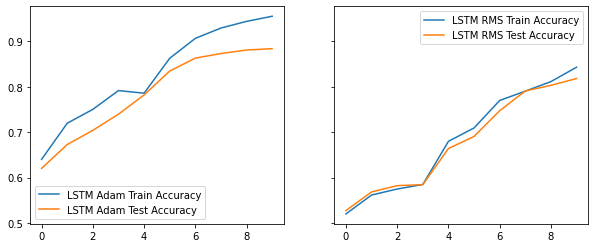

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model.history['train_acc'])), lstm_model.history['train_acc'], 
         label='LSTM Adam Train Accuracy');
ax1.plot(range(len(lstm_model.history['eval_acc'])), lstm_model.history['eval_acc'], 
         label='LSTM Adam Test Accuracy');

ax2.plot(range(len(lstm_model_RMS.history['train_acc'])), lstm_model_RMS.history['train_acc'],
         label='LSTM RMS Train Accuracy');
ax2.plot(range(len(lstm_model_RMS.history['eval_acc'])), lstm_model_RMS.history['eval_acc'],
         label='LSTM RMS Test Accuracy');

ax1.legend();
ax2.legend();
f.savefig('LSTM.png', dpi=f.dpi)

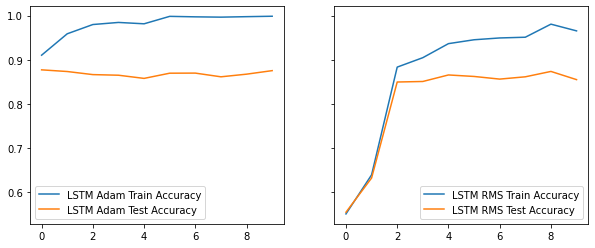

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model_lb.history['train_acc'])), lstm_model_lb.history['train_acc'], 
         label='LSTM Adam Train Accuracy');
ax1.plot(range(len(lstm_model_lb.history['eval_acc'])), lstm_model_lb.history['eval_acc'], 
         label='LSTM Adam Test Accuracy');

ax2.plot(range(len(lstm_model_RMS_lb.history['train_acc'])), lstm_model_RMS_lb.history['train_acc'],
         label='LSTM RMS Train Accuracy');
ax2.plot(range(len(lstm_model_RMS_lb.history['eval_acc'])), lstm_model_RMS_lb.history['eval_acc'],
         label='LSTM RMS Test Accuracy');

ax1.legend();
ax2.legend();
f.savefig('LSTM_lb.png', dpi=f.dpi)

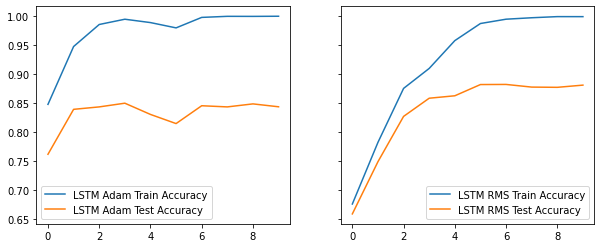

In [46]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model_lb2.history['train_acc'])), lstm_model_lb2.history['train_acc'], 
         label='LSTM Adam Train Accuracy');
ax1.plot(range(len(lstm_model_lb2.history['eval_acc'])), lstm_model_lb2.history['eval_acc'], 
         label='LSTM Adam Test Accuracy');

ax2.plot(range(len(lstm_model_RMS_lb2.history['train_acc'])), lstm_model_RMS_lb2.history['train_acc'],
         label='LSTM RMS Train Accuracy');
ax2.plot(range(len(lstm_model_RMS_lb2.history['eval_acc'])), lstm_model_RMS_lb2.history['eval_acc'],
         label='LSTM RMS Test Accuracy');
ax1.legend();
ax2.legend();
f.savefig('LSTM_lb2.png', dpi=f.dpi)

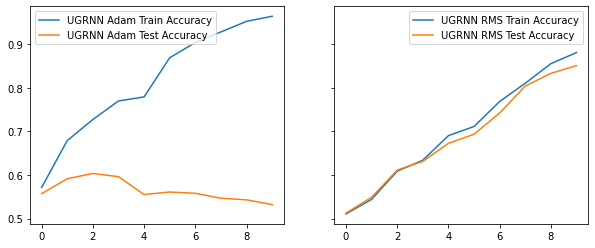

In [47]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(range(len(ugrnn_model.history['train_acc'])), ugrnn_model.history['train_acc'], 
         label='UGRNN Adam Train Accuracy');
ax1.plot(range(len(ugrnn_model.history['eval_acc'])), ugrnn_model.history['eval_acc'], 
         label='UGRNN Adam Test Accuracy');

ax2.plot(range(len(ugrnn_model_RMS.history['train_acc'])), ugrnn_model_RMS.history['train_acc'],
         label='UGRNN RMS Train Accuracy');
ax2.plot(range(len(ugrnn_model_RMS.history['eval_acc'])), ugrnn_model_RMS.history['eval_acc'],
         label='UGRNN RMS Test Accuracy');

ax1.legend();
ax2.legend();
f.savefig('UGRNN.png', dpi=f.dpi)

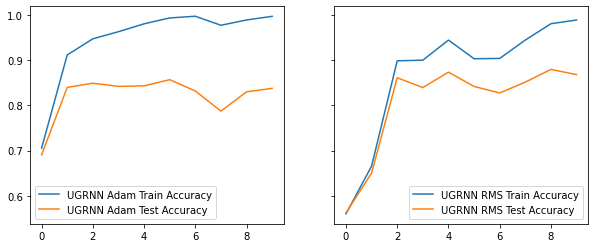

In [58]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(range(len(ugrnn_model_lb.history['train_acc'])), ugrnn_model_lb.history['train_acc'], 
         label='UGRNN Adam Train Accuracy');
ax1.plot(range(len(ugrnn_model_lb.history['eval_acc'])), ugrnn_model_lb.history['eval_acc'], 
         label='UGRNN Adam Test Accuracy');
ax2.plot(range(len(ugrnn_model_RMS_lb.history['train_acc'])), ugrnn_model_RMS_lb.history['train_acc'],
         label='UGRNN RMS Train Accuracy');
ax2.plot(range(len(ugrnn_model_RMS_lb.history['eval_acc'])), ugrnn_model_RMS_lb.history['eval_acc'],
         label='UGRNN RMS Test Accuracy');

ax1.legend();
ax2.legend();
f.savefig('UGRNN_lb.png', dpi=f.dpi)

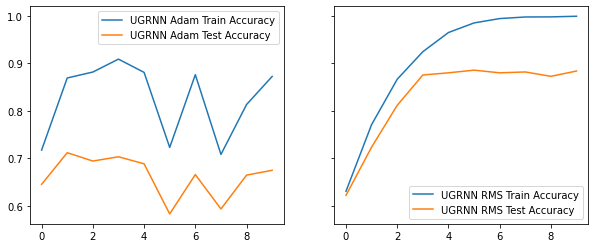

In [59]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(range(len(ugrnn_model_lb2.history['train_acc'])), ugrnn_model_lb2.history['train_acc'], 
         label='UGRNN Adam Train Accuracy');
ax1.plot(range(len(ugrnn_model_lb2.history['eval_acc'])), ugrnn_model_lb2.history['eval_acc'], 
         label='UGRNN Adam Test Accuracy');

ax2.plot(range(len(ugrnn_model_RMS_lb2.history['train_acc'])), ugrnn_model_RMS_lb2.history['train_acc'],
         label='UGRNN RMS Train Accuracy');
ax2.plot(range(len(ugrnn_model_RMS_lb2.history['eval_acc'])), ugrnn_model_RMS_lb2.history['eval_acc'],
         label='UGRNN RMS Test Accuracy');

ax1.legend();
ax2.legend();
f.savefig('UGRNN_lb2.png', dpi=f.dpi)

## Test network on new samples
---



In [60]:
###############################################################
# Import/download necessary libraries to process new sequences
###############################################################
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re

In [61]:
def process_new_review(review):
    '''Function to process a new review.
       Args:
           review: original text review, string.
       Returns:
           indexed_review: sequence of integers, words correspondence 
                           from word2idx.
           seq_length: the length of the review.
    '''
    indexed_review = re.sub(r'<[^>]+>', ' ', review)
    indexed_review = word_tokenize(indexed_review)
    indexed_review = [word2idx[word] if word in list(word2idx.keys()) else 
                      word2idx['Unknown_token'] for word in indexed_review]
    indexed_review = indexed_review + [word2idx['End_token']]
    seq_length = len(indexed_review)    
    return indexed_review, seq_length

In [62]:
sent_dict = {0: 'negative', 1: 'positive'}

In [63]:
review_score_10 = "I think Bad Apples is a great time and I recommend! I enjoyed the opening, which gave way for the rest of the movie to occur. The main couple was very likable and I believed all of their interactions. They had great onscreen chemistry and made me laugh quite a few times! Keeping the girls in the masks but seeing them in action was something I loved. It kept a mystery to them throughout. I think the dialogue was great. The kills were fun. And the special surprise gore effect at the end was AWESOME!! I won't spoil that part ;) I also enjoyed how the movie wrapped up. It gave a very urban legends type feel of \"did you ever hear the story...\". Plus is leaves the door open for another film which I wouldn't mind at all. Long story short, I think if you take the film for what it is; a fun little horror flick, then you won't be disappointed! HaPpY eArLy HaLLoWeEn!"

In [64]:
review_score_4 = "A young couple comes to a small town, where the husband get a job working in a hospital. The wife which you instantly hate or dislike works home, at the same time a horrible murders takes place in this small town by two masked killers. Bad Apples is just your tipical B-horror movie with average acting (I give them that. Altough you may get the idea that some of the actors are crazy-convervative Christians), but the script is just bad, and that's what destroys the film."

In [65]:
review_score_1 = "When you first start watching this movie, you can tell its going to be a painful ride. the audio is poor...the attacks by the \"girls\" are like going back in time, to watching the old rocky films, were blows never touched. the editing is poor with it aswell, example the actress in is the bath when her husband comes home, clearly you see her wearing a flesh coloured bra in the bath. no hints or spoilers, just wait till you find it in a bargain basket of cheap dvds in a couple of weeks"

In [66]:
new_reviews = [review_score_10, review_score_4, review_score_1]
scores = [10, 4, 1]

In [67]:

with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = lstm_model.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('Adam LSTM (1024,1e-4) The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

Adam LSTM (1024,1e-4) The sentiment for the review with score 10 was found to be positive
Adam LSTM (1024,1e-4) The sentiment for the review with score 4 was found to be negative
Adam LSTM (1024,1e-4) The sentiment for the review with score 1 was found to be negative


In [70]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = lstm_model_lb.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('Adam LSTM (512,1e-3) The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

Adam LSTM (512,1e-3) The sentiment for the review with score 10 was found to be positive
Adam LSTM (512,1e-3) The sentiment for the review with score 4 was found to be negative
Adam LSTM (512,1e-3) The sentiment for the review with score 1 was found to be negative


In [71]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = lstm_model_lb2.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('Adam LSTM (256,1e-2) The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

Adam LSTM (256,1e-2) The sentiment for the review with score 10 was found to be positive
Adam LSTM (256,1e-2) The sentiment for the review with score 4 was found to be negative
Adam LSTM (256,1e-2) The sentiment for the review with score 1 was found to be negative


In [72]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = lstm_model_RMS.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('RMS LSTM (1024,1e-4) The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

RMS LSTM (1024,1e-4) The sentiment for the review with score 10 was found to be positive
RMS LSTM (1024,1e-4) The sentiment for the review with score 4 was found to be negative
RMS LSTM (1024,1e-4) The sentiment for the review with score 1 was found to be negative


In [73]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = lstm_model_RMS_lb.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('RMS LSTM (512,1e-3) The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

RMS LSTM (512,1e-3) The sentiment for the review with score 10 was found to be positive
RMS LSTM (512,1e-3) The sentiment for the review with score 4 was found to be negative
RMS LSTM (512,1e-3) The sentiment for the review with score 1 was found to be negative


In [74]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = lstm_model_RMS_lb2.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('RMS LSTM (256,1e-2) The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

RMS LSTM (256,1e-2) The sentiment for the review with score 10 was found to be positive
RMS LSTM (256,1e-2) The sentiment for the review with score 4 was found to be negative
RMS LSTM (256,1e-2) The sentiment for the review with score 1 was found to be negative


In [75]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = ugrnn_model.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('Adam UGRNN (1024,1e-4) The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

Adam UGRNN (1024,1e-4) The sentiment for the review with score 10 was found to be positive
Adam UGRNN (1024,1e-4) The sentiment for the review with score 4 was found to be positive
Adam UGRNN (1024,1e-4) The sentiment for the review with score 1 was found to be positive


In [76]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = ugrnn_model_lb.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('ADAM UGRNN (512,1e-3) The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

ADAM UGRNN (512,1e-3) The sentiment for the review with score 10 was found to be positive
ADAM UGRNN (512,1e-3) The sentiment for the review with score 4 was found to be negative
ADAM UGRNN (512,1e-3) The sentiment for the review with score 1 was found to be negative


In [77]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = ugrnn_model_lb2.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('Adam UGRNN (256,1e-2) The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

Adam UGRNN (256,1e-2) The sentiment for the review with score 10 was found to be negative
Adam UGRNN (256,1e-2) The sentiment for the review with score 4 was found to be positive
Adam UGRNN (256,1e-2) The sentiment for the review with score 1 was found to be positive


In [78]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = ugrnn_model_RMS.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('RMS UGRNN (1024,1e-4) The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

RMS UGRNN (1024,1e-4) The sentiment for the review with score 10 was found to be positive
RMS UGRNN (1024,1e-4) The sentiment for the review with score 4 was found to be negative
RMS UGRNN (1024,1e-4) The sentiment for the review with score 1 was found to be negative


In [79]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = ugrnn_model_RMS_lb.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('RMS UGRNN (512,1e-3) The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

RMS UGRNN (512,1e-3) The sentiment for the review with score 10 was found to be positive
RMS UGRNN (512,1e-3) The sentiment for the review with score 4 was found to be negative
RMS UGRNN (512,1e-3) The sentiment for the review with score 1 was found to be negative


In [80]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = ugrnn_model_RMS_lb2.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('RMS UGRNN (256,1e-2) The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

RMS UGRNN (256,1e-2) The sentiment for the review with score 10 was found to be positive
RMS UGRNN (256,1e-2) The sentiment for the review with score 4 was found to be negative
RMS UGRNN (256,1e-2) The sentiment for the review with score 1 was found to be negative
